In [311]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import smfmodel as smm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='anndata')
warnings.filterwarnings("ignore", category=UserWarning, module='anndata')

# Below series of cells is run each time you want to generate new transition matrix solution set

In [313]:
### Generate solutions of transition matrices for the observed proportion sets derived from the HMM predictions ###

## Provide the observed proportions of states ##
# ORDER MATTERS #
# Order is: Both accessible, Promoter only accessible, Neither Accessible, and Enhancer only accessible.
observed_proportions_on = np.array([0.33, 0.19, 0.29, 0.19])
observed_proportions_off = np.array([0.10, 0.04, 0.53, 0.33])

## Define the variance threshold for a successful steady state solution of a transtion matrix ##
variance_threshold = np.array([0.07, 0.07, 0.08, 0.07])
## Define the number of solutions you want
total_matrices = 1000

## Solve for the solutions
transition_matrix_solutions_on = smm.mm.generate_transition_matrix_solutions(observed_proportions_on, variance_threshold, total_matrices, "Active Allele")
transition_matrix_solutions_off = smm.mm.generate_transition_matrix_solutions(observed_proportions_off, variance_threshold, total_matrices, "Silent Allele")


Generating matrices ON: 83017it [00:06, 13404.26it/s, Matrices left=0]          
Generating matrices OFF: 7234956it [07:36, 15839.32it/s, Matrices left=0]       


In [430]:
### Compile transition matrix solutions from each allele into a single AnnData object ###

## The transition names corresponding to the flattened transition matrix
transition_names = ['Both-Promoter_only', 'Both-Enhancer_only', 'Promoter_only-Both', 'Promoter_only-Neither', 'Neither-Promoter_only', 'Neither-Enhancer_only', 'Enhancer_only-Both', 'Enhancer_only-Neither']

# Load adata for each condition
adata_off = smm.mm.load_transitions_into_adata(transition_matrix_solutions_off, transition_names, "Silent")
adata_on = smm.mm.load_transitions_into_adata(transition_matrix_solutions_on, transition_names, "Active")

## Concatenate AnnData objects and save the corresponding transition matrix solutions in the unstructured portion of the AnnData
adata = ad.concat([adata_off, adata_on])
# Set obs columns to type 'category'
for col in adata.obs.columns:
    adata.obs[col] = adata.obs[col].astype('category')
adata.obs_names_make_unique()
adata.uns['Active_transition_matrices'] = transition_matrix_solutions_on
adata.uns['Silent_transition_matrices'] = transition_matrix_solutions_off
adata.uns['Transition_array_state_map'] = {k: v for v, k in enumerate(transition_names)}


/var/folders/xs/t9v34m4x6g3d0qh5vm__7trc0000gn/T/ipykernel_9145/3201129953.py:110: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(transitions_matrix) # Build an AnnData around the ndarray
/var/folders/xs/t9v34m4x6g3d0qh5vm__7trc0000gn/T/ipykernel_9145/3201129953.py:110: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(transitions_matrix) # Build an AnnData around the ndarray


In [431]:
## Append detailed balance deviations for the active allele solutions ##
adata.uns['Active_allele_detailed_balance_all_deviations'] = []
adata.uns['Active_allele_detailed_balance_mean_deviations'] = []
adata.uns['Active_allele_dissipation'] = []
for T in transition_matrix_solutions_on:
    deviations, max_deviation, mean_deviation = detailed_balance_deviation(T)
    adata.uns['Active_allele_detailed_balance_all_deviations'].append(deviations)
    adata.uns['Active_allele_detailed_balance_mean_deviations'].append(mean_deviation)
    dissipation = detailed_balance_deviation_new(T)
    adata.uns['Active_allele_dissipation'].append(dissipation)
    
## Append detailed balance deviations for the silent allele solutions ##
adata.uns['Silent_allele_detailed_balance_all_deviations'] = []
adata.uns['Silent_allele_detailed_balance_mean_deviations'] = []
adata.uns['Silent_allele_dissipation'] = []
for T in transition_matrix_solutions_off:
    deviations, max_deviation, mean_deviation = detailed_balance_deviation(T)
    adata.uns['Silent_allele_detailed_balance_all_deviations'].append(deviations)
    adata.uns['Silent_allele_detailed_balance_mean_deviations'].append(mean_deviation)
    dissipation = detailed_balance_deviation_new(T)
    dissipation = detailed_balance_deviation_new(T)
    adata.uns['Silent_allele_dissipation'].append(dissipation)
    

In [432]:
## Add some scanpy analyses regarding the transition arrays stored in final_adata.X ##
# Calculate neighborhood graph
sc.pp.neighbors(adata)
# Calculate PCA
sc.tl.pca(adata)
# Caclulate UMAP
sc.tl.umap(adata)

In [434]:
## Save the current AnnData object
adata.write("mm_test.h5ad.gz", compression="gzip")
adata

AnnData object with n_obs × n_vars = 2000 × 8
    obs: 'condition'
    uns: 'Active_transition_matrices', 'Silent_transition_matrices', 'Transition_array_state_map', 'Active_allele_detailed_balance_all_deviations', 'Active_allele_detailed_balance_mean_deviations', 'Active_allele_dissipation', 'Silent_allele_detailed_balance_all_deviations', 'Silent_allele_detailed_balance_mean_deviations', 'Silent_allele_dissipation', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Start here if you already have an AnnData object containing the above analyses

In [433]:
adata

AnnData object with n_obs × n_vars = 2000 × 8
    obs: 'condition'
    uns: 'Active_transition_matrices', 'Silent_transition_matrices', 'Transition_array_state_map', 'Active_allele_detailed_balance_all_deviations', 'Active_allele_detailed_balance_mean_deviations', 'Active_allele_dissipation', 'Silent_allele_detailed_balance_all_deviations', 'Silent_allele_detailed_balance_mean_deviations', 'Silent_allele_dissipation', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [316]:
### Start from here if you already have an AnnData object
adata = ad.read_h5ad("mm_test.h5ad.gz")

In [358]:
## Display the state transtion names ##
adata.uns['Transition_array_state_map'].keys()

dict_keys(['Both-Promoter_only', 'Both-Enhancer_only', 'Promoter_only-Both', 'Promoter_only-Neither', 'Neither-Promoter_only', 'Neither-Enhancer_only', 'Enhancer_only-Both', 'Enhancer_only-Neither'])

In [366]:
adata.obs['condition'].cat.categories

Index(['Active', 'Silent'], dtype='object')

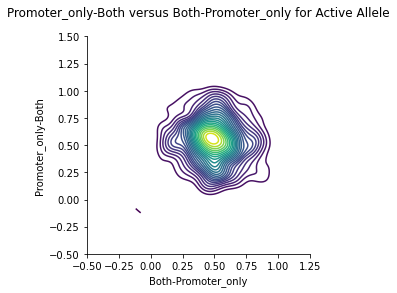

In [367]:
## Example 2D plot of the Promoter only -> Both, vs the Both -> Promoter only kinetics ##
# Below is for the Active allele

x_label = 'Both-Promoter_only'
y_label = 'Promoter_only-Both'
condition = 'Active'
params = {'levels': 25,
          'x_lower': -0.5,
          'x_upper': 1.25,
          'y_lower': -0.5,
          'y_upper': 1.5,
          'save': False}

smm.pl.plot_2D_contour(adata, x_label, y_label, condition, params)

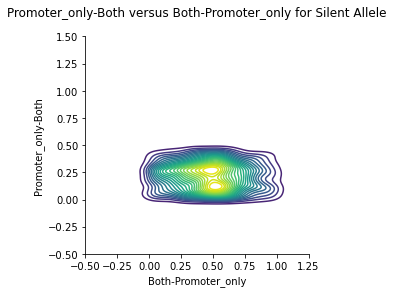

In [368]:
## Example 2D plot of the Promoter only -> Both, vs the Both -> Promoter only kinetics ##
# Below is for the Silent allele

x_label = 'Both-Promoter_only'
y_label = 'Promoter_only-Both'
condition = 'Silent'
params = {'levels': 25,
          'x_lower': -0.5,
          'x_upper': 1.25,
          'y_lower': -0.5,
          'y_upper': 1.5,
          'save': False}

smm.pl.plot_2D_contour(adata, x_label, y_label, condition, params)

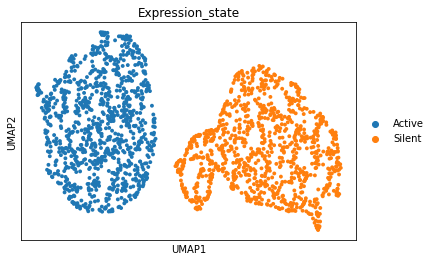

In [369]:
sc.pl.umap(adata, color='Expression_state')

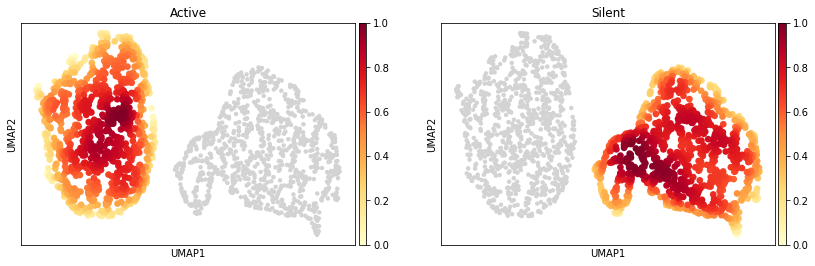

In [370]:
## Plot expression densities on UMAP ##
sc.tl.embedding_density(adata, groupby='Expression_state')
sc.pl.embedding_density(adata, groupby='Expression_state')

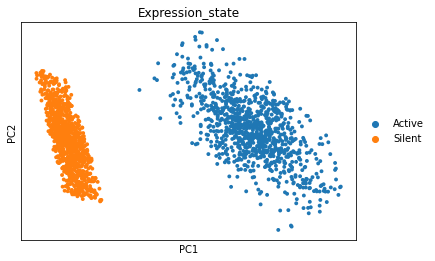

In [371]:
sc.pl.pca(adata, show=True, color='Expression_state')

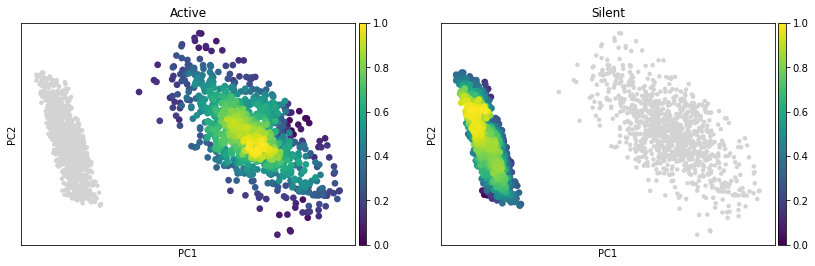

In [372]:
## Plot expression densities on PCA ##
sc.tl.embedding_density(adata, basis='pca', groupby='Expression_state')
sc.pl.embedding_density(adata, basis='pca', groupby='Expression_state', color_map='viridis')

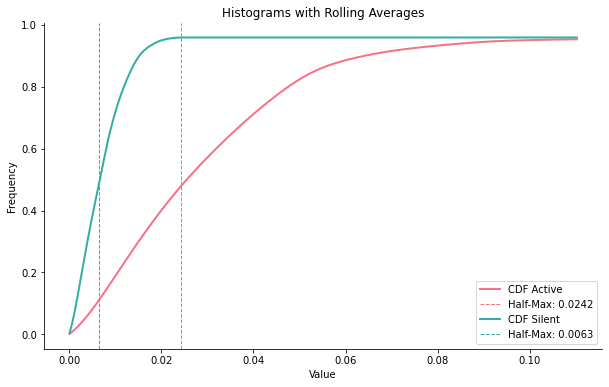

In [428]:
params = {'n_bins': 50,
         'window_size': 2,
         'show_bars': False,
         'show_roll': False,
         'color_palette': 'husl',
         'labels': ['Active', 'Silent'],
          'show_mean': False,
          'show_cdf': True,
         'save': False}

a = adata.uns['Active_allele_detailed_balance_mean_deviations']
b = adata.uns['Silent_allele_detailed_balance_mean_deviations']

smm.pl.plot_hist([a, b], params)

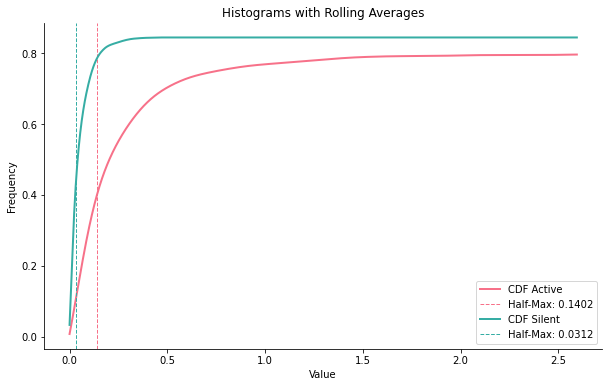

In [429]:
a = adata.uns['Active_allele_dissipation']
b = adata.uns['Silent_allele_dissipation']
smm.pl.plot_hist([a, b], params)